In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

import librosa

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Conv1D, Conv2D, MaxPooling1D, Flatten, LSTM, Activation, Dropout, Dense

Using TensorFlow backend.


## IMPORT DATA

In [2]:
df = pd.read_csv('../data/data.csv')

In [3]:
emotional_decrease = {'neutral' : 'neutral', 'calm' : 'neutral', 'happy' : 'positive', 'sad' : 'negative', 'angry' : 'negative', 'fearful' : 'negative', 'disgust' : 'negative', 'surprised' : 'surprised'}

In [4]:
emotional_decrease = {'neutral' : 'neutral', 'calm' : 'neutral', 'happy' : 'positive', 'sad' : 'negative', 'angry' : 'negative', 'fearful' : 'negative', 'disgust' : 'negative', 'surprised' : 'surprised'}
df['emotion'] = df['emotion'].apply(lambda x: emotional_decrease[x])
df = df[df['emotion'] != 'surprised']

In [5]:
df.head()

,chroma_stft,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc0,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,emotion
0,0.285073,1983.790938,2257.218445,3584.252930,0.075257,-482.625061,98.723747,10.763579,-15.247211,9.086503,...,-1.002849,-7.897387,4.955098,3.673250,4.729796,-2.967993,5.812353,-0.807726,-3.740592,neutral
1,0.317146,2761.827974,2097.267228,4453.485107,0.160061,-236.182678,57.486309,-10.906199,15.691256,-6.170797,...,7.572874,1.293544,0.161986,-6.448635,-6.156417,-0.231544,13.528853,4.967438,18.646177,negative
2,0.278087,2275.676333,2305.452052,4625.024414,0.122916,-260.253021,81.079872,6.040711,1.711222,-39.751842,...,7.407228,-15.825860,8.155030,-5.742045,-7.586360,-5.758427,-1.636331,-10.757888,-1.511348,negative
3,0.266470,2388.422244,2099.641172,4718.381570,0.112948,-293.535797,52.546513,-40.444359,23.320959,-19.301693,...,8.436443,-16.272163,12.842004,-11.418798,-7.661440,-4.796383,-8.022415,-8.520125,-2.734798,positive
4,0.242408,1250.156767,2004.454675,2520.326843,0.026874,-413.931061,105.721146,31.009756,25.187531,-8.839246,...,-2.703896,-7.592486,6.028452,-16.085613,1.451131,-7.485082,-1.111561,-6.581056,-7.937854,negative


In [6]:
from sklearn.utils import shuffle
df = shuffle(df)

## CREATE X AND Y

In [7]:
emotion = df['emotion']
encoder = LabelEncoder()
y = encoder.fit_transform(emotion)

In [8]:
# df.groupby(emotion).count()

In [9]:
encoder.inverse_transform(np.unique(y))

array(['negative', 'neutral', 'positive'], dtype=object)

In [10]:
np.unique(y)

array([0, 1, 2])

In [11]:
scaler = StandardScaler()
X = scaler.fit(np.array(df.iloc[:, :-1], dtype = float))
X = scaler.transform(np.array(df.iloc[:, :-1], dtype = float))
X = X.reshape(X.shape[0], X.shape[1],1)

In [12]:
X[0].shape

(25, 1)

## TRAIN_TEST_SPLIT

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [14]:
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

In [15]:
y_train.shape

(3248, 3)

## MODEL

In [16]:
model = keras.Sequential()

model.add(Conv1D(16, 5,padding='same',
                 input_shape=(25,1)))
model.add(Activation('relu'))
model.add(Conv1D(32, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Conv1D(64, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))

model.add(MaxPooling1D(pool_size=(8)))

model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Dense(64))
model.add(Activation('relu'))
## unstacking rows of pixels in the image and lining them up
model.add(keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])))
## The second (and last) layer is a 10-node softmax layer that 
##    returns an array of 10 probability scores that sum to 1
model.add(keras.layers.Dense(3, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 25, 16)            96        
_________________________________________________________________
activation_1 (Activation)    (None, 25, 16)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 25, 32)            2592      
_________________________________________________________________
activation_2 (Activation)    (None, 25, 32)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25, 32)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 25, 64)            10304     
_________________________________________________________________
activation_3 (Activation)    (None, 25, 64)           

In [18]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history=model.fit(X_train, y_train, batch_size=5, epochs=19, validation_data=(X_test, y_test))

Train on 3248 samples, validate on 813 samples
Epoch 1/19
3248/3248 [==============================] - 3s 858us/step - loss: 0.6847 - accuracy: 0.7180 - val_loss: 0.4767 - val_accuracy: 0.8093
Epoch 2/19
3248/3248 [==============================] - 3s 789us/step - loss: 0.4166 - accuracy: 0.8334 - val_loss: 0.4145 - val_accuracy: 0.8130
Epoch 3/19
3248/3248 [==============================] - 2s 727us/step - loss: 0.3394 - accuracy: 0.8553 - val_loss: 0.3835 - val_accuracy: 0.8426
Epoch 4/19
3248/3248 [==============================] - 2s 741us/step - loss: 0.3072 - accuracy: 0.8787 - val_loss: 0.3533 - val_accuracy: 0.8549
Epoch 5/19
3248/3248 [==============================] - 3s 859us/step - loss: 0.2579 - accuracy: 0.8895 - val_loss: 0.3403 - val_accuracy: 0.8770
Epoch 6/19
3248/3248 [==============================] - 3s 915us/step - loss: 0.2321 - accuracy: 0.9046 - val_loss: 0.3213 - val_accuracy: 0.8758
Epoch 7/19
3248/3248 [==============================] - 3s 830us/step - loss:

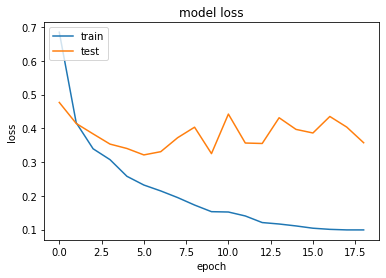

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [20]:
score = model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

accuracy: 87.95%


## PREDICTIONS

In [21]:
preds = model.predict(X_test, 
                         batch_size= 5,
                         verbose=1)

preds1=preds.argmax(axis=1)
abc = preds1.astype(int).flatten()
predictions = (encoder.inverse_transform((abc)))

813/813 [==============================] - 0s 256us/step


In [22]:
preddf = pd.DataFrame({'predictedvalues': predictions})
actual=y_test.argmax(axis=1).astype(int).flatten()
actualvalues = (encoder.inverse_transform((actual)))
actualdf = pd.DataFrame({'actualvalues': actualvalues})
finaldf = actualdf.join(preddf)
finaldf

,actualvalues,predictedvalues
0,negative,negative
1,positive,positive
2,neutral,negative
3,negative,negative
4,positive,negative
5,negative,negative
6,negative,negative
7,neutral,neutral
8,negative,negative
9,positive,positive


In [23]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
negative,521
neutral,162
positive,130


In [24]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
negative,553
neutral,157
positive,103


## PICKLE MODEL

In [25]:
import pickle

pickle.dump(model, open('../pickles/emotion_model.p','wb'))
pickle.dump(encoder, open('../pickles/emotion_encoder.p','wb'))
pickle.dump(scaler, open('../pickles/emotion_scaler.p','wb'))

In [26]:
# pickle_model = pickle.load(open('model.p','rb'))